## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

from PIL import Image
from IPython.display import display

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load RetinaNet model

In [2]:
model = models.load_model(
    'keras-retinanet/inference_resnet50_csv_50.h5',
    backbone_name='resnet50'
)
labels_to_names = {0: 'building'}

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Run detection on test

In [3]:
def get_boxes(filename):
    
    image = read_image_bgr(filename)  #[:3000,:3000]

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    scale = 0.1
    image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # remove [-1,-1,-1,-1] boxes
    boxes = boxes[np.nonzero(~np.all(boxes == -1., axis=-1))]
    
    # correct for image scale
    boxes /= scale
    boxes = boxes.astype('int')

    # visualize detections
    for box, score, label in zip(boxes, scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
        
    basename = filename.rsplit('.', 1)[0]
    Image.fromarray(draw).save(basename + '_boxes.jpg')
    np.savetxt(basename + '_boxes.txt', boxes[0], '%d')

    return draw, boxes

In [4]:
all_boxes = []
for i in os.listdir('/root/data/test'):
    if 'boxes' in i:
        continue
    draw, boxes = get_boxes('/root/data/test/' + i)
    for j in boxes:
        all_boxes.append((i,) + tuple(j))

processing time:  2.9135406017303467
processing time:  0.05518770217895508
processing time:  0.05455183982849121


In [5]:
import pandas as pd
df = pd.DataFrame(all_boxes, columns=['filename', 'x1', 'y1', 'x2', 'y2'])
df.to_csv('boxes.csv', index=False)

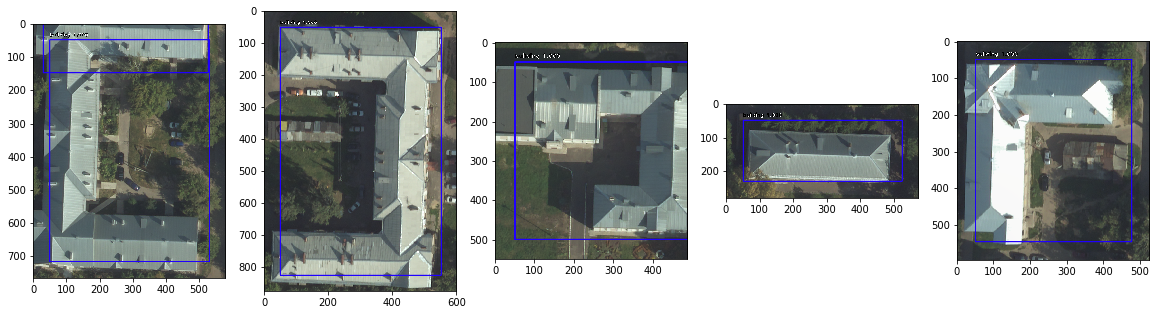

In [6]:
plt.figure(figsize=(20, 10))
for n, (x1, y1, x2, y2) in enumerate(boxes[:5]):
    plt.subplot(1, 5, n + 1)
    plt.imshow(draw[y1-50:y2+50, x1-50:x2+50])
plt.show()